
--- Logistic Regression ---
Accuracy: 0.7928571428571428
Precision: 0.4358974358974359
Recall: 0.7083333333333334
F1-Score: 0.5396825396825397
ROC-AUC: 0.8265086206896552

Confusion Matrix:
 [[94 22]
 [ 7 17]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.81      0.87       116
           1       0.44      0.71      0.54        24

    accuracy                           0.79       140
   macro avg       0.68      0.76      0.70       140
weighted avg       0.85      0.79      0.81       140



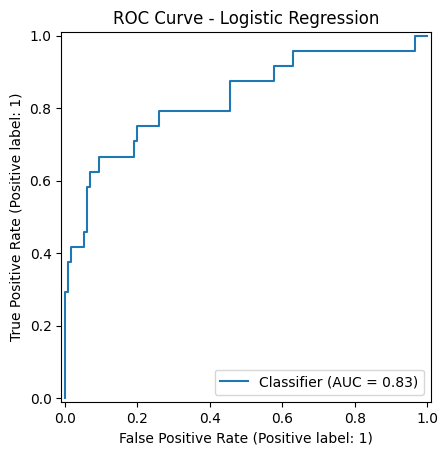


--- Random Forest ---
Accuracy: 0.8571428571428571
Precision: 1.0
Recall: 0.16666666666666666
F1-Score: 0.2857142857142857
ROC-AUC: 0.7945402298850575

Confusion Matrix:
 [[116   0]
 [ 20   4]]

Classification Report:
               precision    recall  f1-score   support

           0       0.85      1.00      0.92       116
           1       1.00      0.17      0.29        24

    accuracy                           0.86       140
   macro avg       0.93      0.58      0.60       140
weighted avg       0.88      0.86      0.81       140



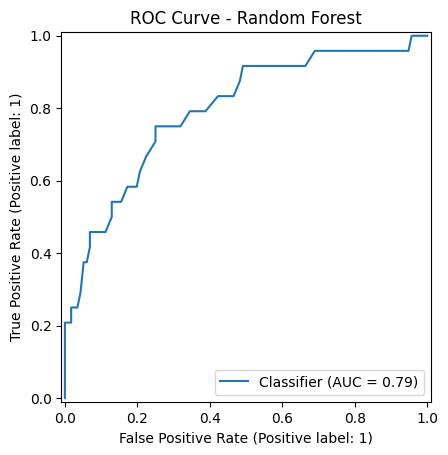


=== Model Comparison ===
                     Accuracy  Precision    Recall  F1-Score   ROC-AUC
Logistic Regression  0.792857   0.435897  0.708333  0.539683  0.826509
Random Forest        0.857143   1.000000  0.166667  0.285714  0.794540

✅ Best model: Logistic Regression
✅ Saved attrition_model.pkl, scaler.pkl, and columns.pkl for Streamlit app.


In [ ]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay
)

# ===============================
# 1. Load Dataset
# ===============================
df_original = pd.read_csv(r"C:\Users\HP\Downloads\Datascience_3rd_project\employee_attrition.csv")
df = df_original.copy()

# Drop constant/unneeded columns
drop_cols = ["EmployeeCount", "EmployeeNumber", "Over18", "StandardHours"]
df.drop(columns=drop_cols, inplace=True, errors="ignore")

# Standardize column names
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

# ===============================
# 2. Handle outliers (optional)
# ===============================
num_cols = df.select_dtypes(include=["int64", "float64"]).columns
for col in num_cols:
    if col == "attrition":
        continue
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    df = df[(df[col] >= lower) & (df[col] <= upper)]

# ===============================
# 3. Encoding categorical variables
# ===============================
cat_cols = df.select_dtypes(include=["object"]).columns
binary_cols = [col for col in cat_cols if df[col].nunique() == 2]
multi_cols = [col for col in cat_cols if df[col].nunique() > 2]

label_enc = LabelEncoder()
for col in binary_cols:
    df[col] = label_enc.fit_transform(df[col])

df = pd.get_dummies(df, columns=multi_cols, drop_first=True)

# ===============================
# 4. Feature scaling
# ===============================
scaler = StandardScaler()
cont_cols = [col for col in df.select_dtypes(include=["int64", "float64"]).columns
             if col != "attrition" and df[col].nunique() > 2]

df[cont_cols] = scaler.fit_transform(df[cont_cols])

# ===============================
# 5. Train-test split
# ===============================
X = df.drop("attrition", axis=1)
y = df["attrition"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ===============================
# 6. Train models
# ===============================
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42)
}

results = {}
trained_models = {}

def evaluate_model(y_true, y_pred, y_prob, model_name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc = roc_auc_score(y_true, y_prob)

    results[model_name] = {"Accuracy": acc, "Precision": prec, "Recall": rec, "F1-Score": f1, "ROC-AUC": roc}

    print(f"\n--- {model_name} ---")
    print("Accuracy:", acc)
    print("Precision:", prec)
    print("Recall:", rec)
    print("F1-Score:", f1)
    print("ROC-AUC:", roc)
    print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred))

    RocCurveDisplay.from_predictions(y_true, y_prob)
    plt.title(f"ROC Curve - {model_name}")
    plt.show()

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    evaluate_model(y_test, y_pred, y_prob, name)
    trained_models[name] = model

# ===============================
# 7. Select best model by ROC-AUC
# ===============================
results_df = pd.DataFrame(results).T
best_model_name = results_df["ROC-AUC"].idxmax()
best_model = trained_models[best_model_name]

print("\n=== Model Comparison ===")
print(results_df)
print(f"\n✅ Best model: {best_model_name}")

# ===============================
# 8. Feature importance (Random Forest)
# ===============================
if best_model_name == "Random Forest":
    feat_imp = pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=False)[:10]
    plt.figure(figsize=(8,5))
    sns.barplot(x=feat_imp, y=feat_imp.index, palette="Set2")
    plt.title("Top 10 Feature Importances (Random Forest)")
    plt.show()

# ===============================
# 9. Save model, scaler, columns for Streamlit
# ===============================
with open("attrition_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

with open("columns.pkl", "wb") as f:
    pickle.dump(X.columns.tolist(), f)

print("✅ Saved attrition_model.pkl, scaler.pkl, and columns.pkl for Streamlit app.")